In [28]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin

pd.set_option("display.max_columns",30)

Location

The common name of the location of the weather station


MinTemp

The minimum temperature in degrees celsius


MaxTemp

The maximum temperature in degrees celsius


Rainfall

The amount of rainfall recorded for the day in mm


Evaporation

The so-called Class A pan evaporation (mm) in the 24 hours to 9am


Sunshine

The number of hours of bright sunshine in the day.


WindGustDir

The direction of the strongest wind gust in the 24 hours to midnight


WindGustSpeed

The speed (km/h) of the strongest wind gust in the 24 hours to midnight


WindDir9am

Direction of the wind at 9am


WindDir3pm

Direction of the wind at 3pm


WindSpeed9am

Wind speed (km/hr) averaged over 10 minutes prior to 9am


WindSpeed3pm

Wind speed (km/hr) averaged over 10 minutes prior to 3pm


Humidity9am

Humidity (percent) at 9am


Humidity3pm

Humidity (percent) at 3pm


Pressure9am

Atmospheric pressure (hpa) reduced to mean sea level at 9am


Pressure3pm

Atmospheric pressure (hpa) reduced to mean sea level at 3pm


Cloud9am

Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.


Cloud3pm

Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values


Temp9am

Temperature (degrees C) at 9am


Temp3pm

Temperature (degrees C) at 3pm


RainToday

Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0


RainTomorrow

The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".

In [29]:
data = pd.read_csv("../data/weatherAUS.csv")

In [30]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [31]:
data["Date"] = pd.to_datetime(data["Date"])

In [32]:
(data.isnull().sum()/data.shape[0]).sort_values(ascending=False)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
RainToday        0.022419
Rainfall         0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
WindSpeed9am     0.012148
Temp9am          0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

In [33]:
data.dropna(subset=["RainTomorrow"],inplace=True)
data.reset_index(drop=True,inplace=True)

In [34]:
continuous_features  = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
                        'Humidity9am','Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',       'Temp9am', 'Temp3pm']

In [35]:
target = "RainTomorrow"

In [36]:
discrete_features = list(filter(lambda feature : feature not in continuous_features+[target,"Date","Location"], data.columns))
discrete_features

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [37]:
data["WindGustDir"].value_counts(1)

W      0.073610
SE     0.070065
E      0.068273
N      0.067987
SSE    0.067686
S      0.067355
WSW    0.066994
SW     0.066211
SSW    0.064804
WNW    0.060709
NW     0.060235
ENE    0.060152
ESE    0.054981
NE     0.053137
NNW    0.049382
NNE    0.048418
Name: WindGustDir, dtype: float64

In [38]:

data["Location"].value_counts(1)

Canberra            0.024038
Sydney              0.023468
Perth               0.022455
Darwin              0.022448
Hobart              0.022420
Brisbane            0.022230
Adelaide            0.021731
Bendigo             0.021337
Townsville          0.021330
AliceSprings        0.021316
MountGambier        0.021309
Ballarat            0.021295
Launceston          0.021295
Albany              0.021211
Albury              0.021175
MelbourneAirport    0.021161
PerthAirport        0.021161
Mildura             0.021147
SydneyAirport       0.021133
Nuriootpa           0.021112
Sale                0.021098
Watsonia            0.021091
Tuggeranong         0.021084
Portland            0.021070
Woomera             0.021028
Cairns              0.021014
Cobar               0.021014
Wollongong          0.020979
GoldCoast           0.020957
WaggaWagga          0.020929
Penrith             0.020845
NorfolkIsland       0.020845
Newcastle           0.020782
SalmonGums          0.020782
CoffsHarbour  

In [39]:
data[continuous_features].describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [13]:
class DiscreteTransformer(TransformerMixin):
    def __init__(self,discrete_features):
        self.discrete_features = discrete_features
        
    def fit(self,X,y=None):
        X_ = X.copy()
        X_ = X_[self.discrete_features]
        self.to_impute_most_frequent = X_.mode().T[0].to_dict()
        return self
    
    def transform(self,X):
        X_ = X.copy()
        X_ = X_.fillna(self.to_impute_most_frequent)
        return X_

In [14]:
class WindDirectionTransformer(TransformerMixin):
    def __init__(self,wind_features):
        self.wind_features = wind_features
        
    def fit(self,X,y=None):
        self.wind_direction_order = ["N","NNE","NE","ENE","E","ESE","SE","SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
        self.wind_direction_order = dict(enumerate(self.wind_direction_order))
        self.wind_direction_order = {value:key for key,value in self.wind_direction_order.items()}
        print(self.wind_direction_order)
        return self
    
    def transform(self,X):
        X_ = X.copy()
        X_[self.wind_features] = X_[self.wind_features].replace(self.wind_direction_order)
        return X_


        
    
class BinarizeTransformer(TransformerMixin):
    
    def __init__(self,bin_feature):
        self.bin_feature = bin_feature
        
    def fit(self,X,y=None):
        
        self.values = X[self.bin_feature].unique()
        self.values = dict(enumerate(self.values))
        self.values = {value:key for key,value in self.values.items()}        
        return self
    
    def transform(self,X):
        X_ = X.copy()
        X_[self.bin_feature] = X_[self.bin_feature].replace(self.values)
        return X_

In [40]:
X = data[continuous_features+discrete_features]
y = data[target]

In [41]:
X.isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
WindGustDir       9330
WindDir9am       10013
WindDir3pm        3778
RainToday         1406
dtype: int64

In [42]:
discrete_features

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [43]:
most_frequent = DiscreteTransformer(discrete_features)

most_frequent.fit_transform(X).isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
WindGustDir          0
WindDir9am           0
WindDir3pm           0
RainToday            0
dtype: int64

In [44]:
steps = [
         ("discrete_imputer",DiscreteTransformer(discrete_features)),
         ("wind_transformer",WindDirectionTransformer(discrete_features)),
         ("binarize",BinarizeTransformer("RainToday")),
         ("continuous_imputer", SimpleImputer(strategy="median")),
         ("standar", StandardScaler()) ,
         ("pca", PCA(4)),
        ]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [46]:
pipe = Pipeline(steps = steps)

In [47]:
X_train_preprocess = pd.DataFrame(pipe.fit_transform(X_train),columns= ["p0","p1","p2","p3"])
X_test_preprocess  = pd.DataFrame( pipe.transform(X_test), columns= ["p0","p1","p2","p3"])

{'N': 0, 'NNE': 1, 'NE': 2, 'ENE': 3, 'E': 4, 'ESE': 5, 'SE': 6, 'SSE': 7, 'S': 8, 'SSW': 9, 'SW': 10, 'WSW': 11, 'W': 12, 'WNW': 13, 'NW': 14, 'NNW': 15}


In [48]:
X_train_preprocess

,p0,p1,p2,p3
0,-0.713196,3.056519,-0.877248,-1.455565
1,0.104715,1.638759,2.969207,0.267371
2,-0.418400,3.961993,1.009706,0.008076
3,3.012252,1.576554,-1.474761,0.002103
4,-2.131693,-3.041795,0.140594,-0.480796
...,...,...,...,...
95264,-1.307871,1.273325,-1.067734,-0.797539
95265,-2.463134,1.406708,1.260533,-1.464932
95266,2.702944,-1.755824,-2.763770,0.100423
95267,-0.937179,0.511942,0.349778,1.030518


In [ ]:
pd.DataFrame(pipe[:-2].transform(X_train),columns = X_train.columns)

In [49]:
pipe.steps

[('discrete_imputer', <__main__.DiscreteTransformer at 0x7fe9ace7c9e8>),
 ('wind_transformer', <__main__.WindDirectionTransformer at 0x7fe9ace7ca90>),
 ('binarize', <__main__.BinarizeTransformer at 0x7fe9ace7ca58>),
 ('continuous_imputer', SimpleImputer(strategy='median')),
 ('standar', StandardScaler()),
 ('pca', PCA(n_components=4))]

In [50]:
pipe.steps[-1]

('pca', PCA(n_components=4))

In [51]:
pipe.steps[-1][-1]

PCA(n_components=4)

In [52]:
pipe.steps[-1][-1].explained_variance_ratio_.sum()

0.6166830671781661

In [53]:
pipe.steps[4][-1].inverse_transform

<bound method StandardScaler.inverse_transform of StandardScaler()>

<AxesSubplot:xlabel='p2', ylabel='p3'>

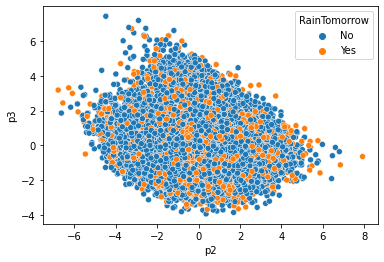

In [54]:
sns.scatterplot(data = X_train_preprocess,x="p2",y="p3",hue=y_train)